In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
print("worked")

worked


In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [29]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect,desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model,check what classes I have
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Cursory glance at data 

In [24]:
# See first lines of station
engine.execute('SELECT * FROM station LIMIT 11').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [10]:
# See first lines of measurement
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
# Find column names and types from Station
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
#Do the same for measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

In [67]:
#Find earliest date in the data set.
session.query(measurement.date).order_by(measurement.date).first()

('2010-01-01',)

In [61]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.date(2017,8,23)
# Calculate the date one year from the last date in data set.
year_ago = dt.date(recent_date.year - 1,recent_date.month,recent_date.day)

# Perform a query to retrieve the data and precipitation scores
data = [measurement.date,measurement.prcp]
year_results = session.query(*data).filter(measurement.date >= year_ago).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(year_results,columns = ["date","prcp"])
#Sort the dataframe by date
rain_df = df.sort_values("date")
rain_df = rain_df.dropna(how = "any")
rain_df

,date,prcp
0,2016-08-23,0.00
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
1881,2016-08-23,0.70
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


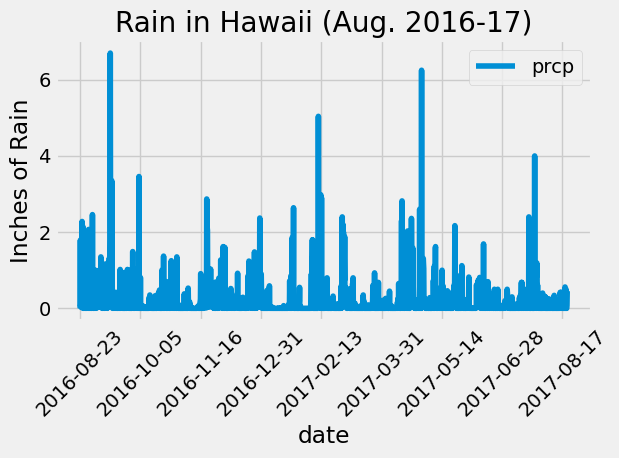

In [62]:
# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot(x = "date", y = "prcp")
plt.xticks(rotation = 45)
plt.ylabel("Inches of Rain")
plt.title("Rain in Hawaii (Aug. 2016-17)")
plt.tight_layout()
plt.show()

In [51]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_df["prcp"].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.id).count()

9

In [31]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(desc(func.count(measurement.station))).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
results = [measurement.station, 
          func.min(measurement.tobs),
          func.max(measurement.tobs),
          func.avg(measurement.tobs)]
session.query(*results).\
filter(measurement.station == "USC00519281").\
group_by(measurement.station).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [63]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = [measurement.date,measurement.tobs]
temp_results = session.query(*temps).filter(measurement.date >= year_ago).\
filter(measurement.station == "USC00519281").all()

df = pd.DataFrame(temp_results,columns = ["Date","Temp"])
temp_df = df.sort_values


,Date,Temp
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


Text(0.5, 1.0, 'Hawaii Temps Aug. 2016-17')

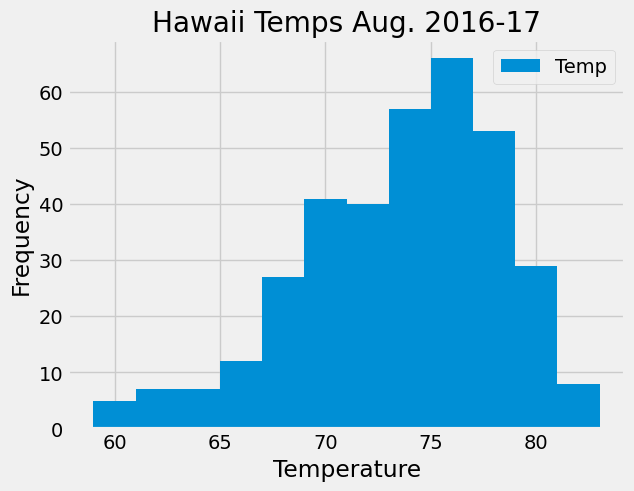

In [66]:
df.plot.hist(bins = 12)
plt.xlabel("Temperature")
plt.title("Hawaii Temps Aug. 2016-17")

# Close Session

In [44]:
# Close Session
session.close()